# FCN Semantik Bölütleme Örneği

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import cv2
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'  

In [2]:
# caffe başlanıç ayarlarını yapıyoruz
# hesaplamalarda ggpu kullanalım ilk - 0 - gpu kullanılsın 
caffe.set_device(0)  
caffe.set_mode_gpu()
# Model tanım ve ağırlık dosyalarını belirtim bir ağ nesnesi oluşturuyoruz
model_def = 'fcn8s-heavy-pascal.prototxt'
model_weights ='fcn8s-heavy-pascal.caffemodel'
net = caffe.Net(model_def,model_weights,caffe.TEST)    

In [3]:
# Ağ girişi nitelikleri sabit olduğundan 
# Çalıştırmak için giriş vermeden önce giriş resmine gereken işlemleri uygulamamız gerekiyor
# bu iş için Datanın şeklini belirterek, Transformer nesnesi oluşturuyoruz
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
# görüntü matrisinde kanal sayısını başa alıyoruz  (height, width, channel ) - >  (channel,height, width )
transformer.set_transpose('data', (2,0,1))  
# piksel min max aralığını [0, 255]  arasına ölçeklendiriyoruz
transformer.set_raw_scale('data', 255)      
# RGB şeklinde okunmuş veriyi BGR çeviriyoruz 
transformer.set_channel_swap('data', (2,1,0))  

In [4]:
net.blobs['data'].reshape(1,3,500, 500) 

C:\Anaconda2\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


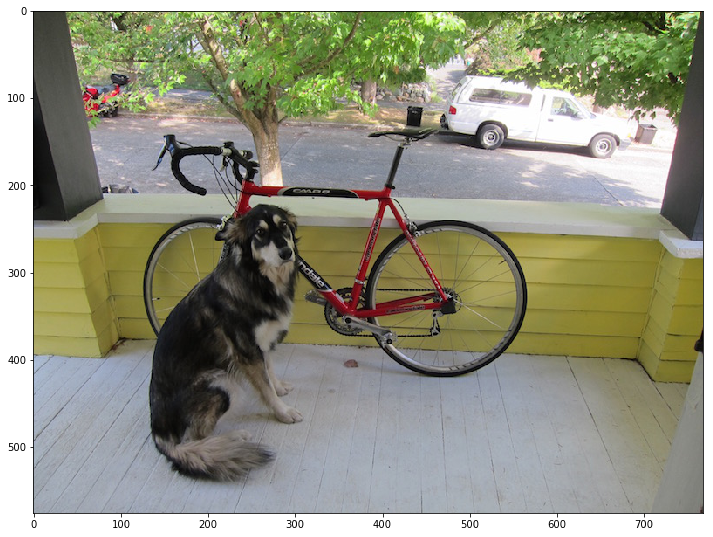

In [5]:
image = caffe.io.load_image('dog.jpg')
transformed_image = transformer.preprocess('data', image)
plt.figure(figsize=(12,12))
plt.imshow(image)

In [32]:
# Girişimiz veriyoruz
net.blobs['data'].data[...] = transformed_image
# Ağı çalıştrıp sonucu alıyoruz.
%time output = net.forward()

Wall time: 909 ms


In [31]:
# Sonuçdan skoru çekiyoruz
out = output['score']

In [8]:
# Sonucumuzun ebatına bakıyoruz.
out.shape

(1L, 21L, 500L, 500L)

In [16]:
class_names = {u'Arka Plan':0,
               u'Uçak':1,
               u'Bisiklet':2,
               u'Kuş':3,
               u'Bot':4,     
               u'Şişe':5,
               u'Otobüs':6,
               u'Araba':7,
               u'Kedi':8,                
               u'Sandalye':9,
               u'İnek':10,
               u'Yemek Masası':11,
               u'Köpek':12,
               u'At':13,     
               u'Motorsiklet':14,
               u'İnsan':15,
               u'Saksı Bitkisi':16,
               u'Koyun':17,                
               u'Kanepe':18,  
               u'Tren':19,                
               u'TV Monitör':20 }     
               

In [17]:
seg_out = out.copy().reshape((21,500,500))

In [18]:
# bir vektörün maksimum değerini 1 diğerlerini 0 değerine eşitleyen fonksiyon eşik değer fonksiyonu
def thresh(l):
    th = 0.65*l.max()
    l[l<th] = 0.0
    l[l>=th] = 1.0

In [19]:
# sonuç matrisimizi piksel bazlı eşik değer fonksiyonuna sokmak için 
# 21 uzunluğunda 500*500 = 250 000 vektöre çeviriyoruz
thresh_out  = seg_out.copy().reshape((21,500*500))
# her vektör için eşik değer fonksiyonu uyguluyoruz.
_ = map(thresh,[thresh_out[:,i] for i  in range(500*500)])
# yeniden eski haline, matrise dönüştürüyoruz
thresh_out = thresh_out.reshape((21,500,500))

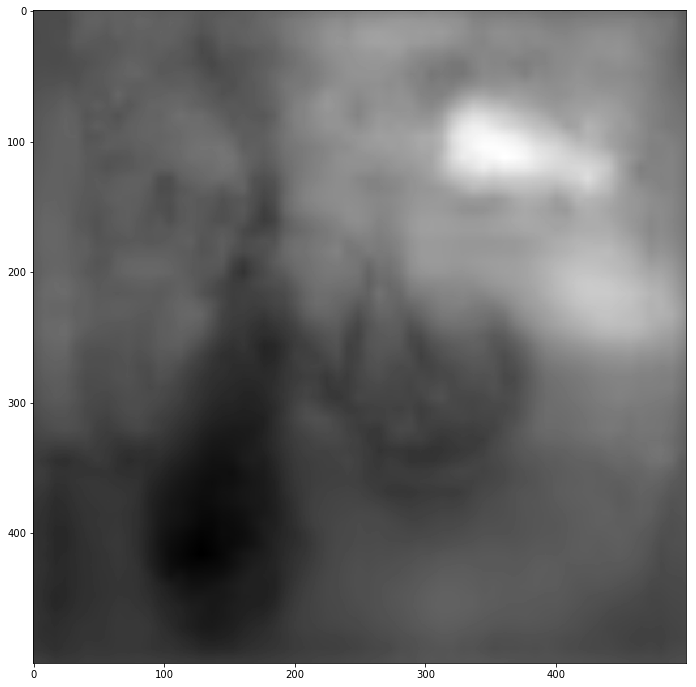

In [24]:
# Piksel bazında ihtimal göstermek istiyoruz
# Görmek istediğimiz sınıfı seçiyoruz
item = class_names[u'Köpek']
item = 7
plt.figure(figsize=(12,12))
# Seçtiğimiz sınıfa ait katmanı gösteriyoruz
plt.imshow(seg_out[item,:,:])

In [25]:
#item =12
# Seçtiğimiz sınıfı gösteren katmanı 3 kanallı görüntüye çeviriyoruz
item_imag = cv2.cvtColor(thresh_out[item,:,:],cv2.COLOR_GRAY2BGR)
# Ebatını giiriş resmi ebatına çeviriyoruz
item_imag = cv2.resize(item_imag,(image.shape[1],image.shape[0]))

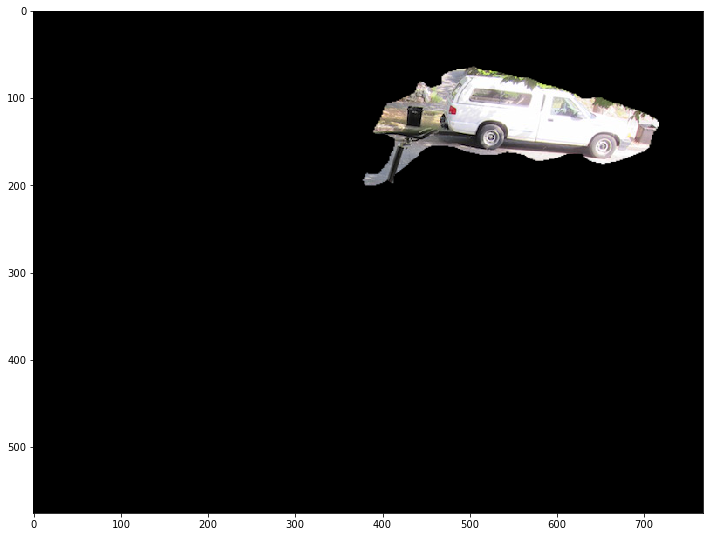

In [26]:
# Eşik değer işleminden geçmiş katmanların seçitiğimiz sınıfı göstermek için orjinal görüntüyle birlikte gösteriyoruz.
plt.figure(figsize=(12,12))
plt.imshow(item_imag*image) 